In [4]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import pandas_gbq
import matplotlib.pyplot as plt
import folium
import folium.plugins as plugins

In [5]:
global client_destination
global sqlQuery
client_destination = bigquery.Client("bi-psel")

In [6]:
## Gera graficos de calor e cluster para os dados

## Conecta e coleta latitudes e longitudes do banco
sqlQuery = """
SELECT Latitude,Longitude FROM `bi-psel.rafael_rosario.austin-incidents` Where Latitude is not null and Longitude is not null
"""
df = pandas_gbq.read_gbq(sqlQuery, project_id="bi-psel")

## Limpa dados invalidos para a cidade de Austin
df.drop(df[ df['Latitude'] < 30 ].index , inplace=True)
df.drop(df[ df['Longitude'] > -97 ].index , inplace=True)

# Gera um mapa centralizado em austin
base_map_heat = folium.Map(location= [df['Latitude'].median(), df['Longitude'].median()], control_scale=True,zoom_start=15)
base_map_cluster = folium.Map(location= [df['Latitude'].median(), df['Longitude'].median()], control_scale=True,zoom_start=15)

# Convert os pontos em uma lista e adiciona em um mapa de calor
folium.plugins.HeatMap([[row['Latitude'],row['Longitude']] for index, row in df.iterrows()]).add_to(base_map_heat)
folium.plugins.MarkerCluster([[row['Latitude'],row['Longitude']] for index, row in df.iterrows()]).add_to(base_map_cluster)

# Mostra os mapas criados
display(base_map_heat)
display(base_map_cluster)

Downloading: 100%|█████████████████████████████████████████████████████████████| 3378/3378 [00:00<00:00, 4305.27rows/s]


Downloading: 100%|██████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 249.66rows/s]


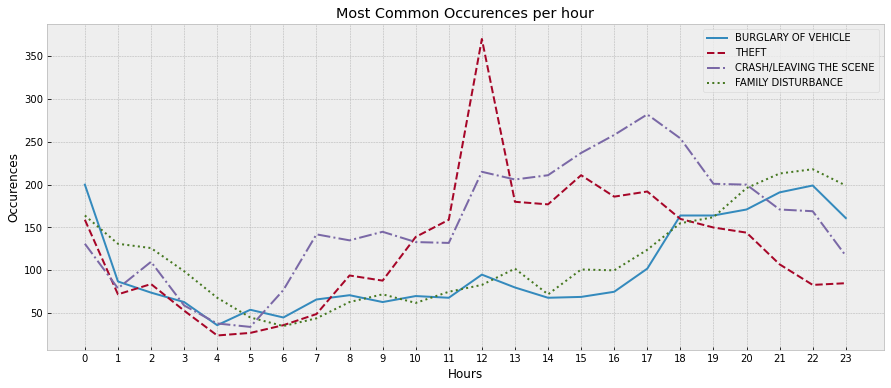

In [7]:
##Gera grafico de Linhas com relação Crime/Hora do dia

##Coleta 4 ocorrencias mais comuns separadas por hora da ocorrencia
sqlQuery = """
SELECT
EXTRACT(HOUR FROM Time) AS TimeHour,
Descript,
Count(*) AS Occurences 
FROM `bi-psel.rafael_rosario.austin-incidents`
WHERE Descript IN(SELECT Descript FROM `bi-psel.rafael_rosario.austin-incidents` GROUP BY Descript ORDER BY COUNT(*) DESC LIMIT 4)
GROUP BY 1,2 ORDER BY 1"""

df = pandas_gbq.read_gbq(sqlQuery, project_id="bi-psel")

##Separa os dados por descrição do crime e prepara os 4 diferentes estilos de linha
lista_descripts = df["Descript"].unique()
line_style = {0:'-',1 : '--',2:'-.',3:':'}
line_number = 0
lista_ordenada = []
plt.style.use("bmh")
plt.figure(figsize=(15,6))
##Percorre a lista de cada descrição criando as linhas
for descript in lista_descripts:
    tempdf = df.query("Descript == '"+descript+"'")
    plt.plot(tempdf["TimeHour"], tempdf["Occurences"], label = descript, linestyle = line_style[line_number])
    line_number += 1
##Define e demonstra as linhas no grafico
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hours')
plt.ylabel('Occurences')
plt.title('Most Common Occurences per hour')
plt.legend()
plt.show()

Downloading: 100%|██████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 170.38rows/s]


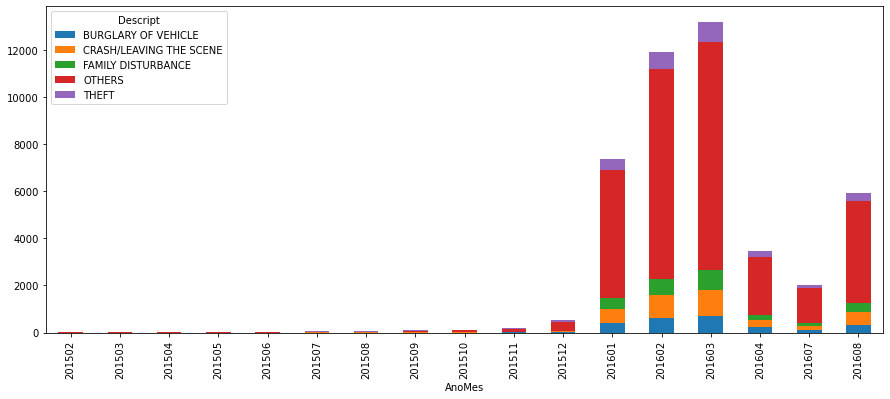

In [3]:
##Coleta 4 ocorrencias mais comuns separadas por hora da ocorrencia
sqlQuery = """
SELECT 
    coalesce(FORMAT_DATE("%Y%m",A.Date),AnoMes_Aux) as AnoMes,
    case when Descript_aux is null then 'OTHERS' else Descript_aux end as Descript, 
    SUM(case when a.Descript is null then 0 else 1 end) as Occurences
FROM `bi-psel.rafael_rosario.austin-incidents` AS A
Full outer Join (
(SELECT Descript as Descript_aux from `bi-psel.rafael_rosario.austin-incidents` group by 1 order by Count(*) DESC LIMIT 4 )
CROSS JOIN 
(select FORMAT_DATE("%Y%m",Date) as AnoMes_Aux from `bi-psel.rafael_rosario.austin-incidents` group by 1)
) on FORMAT_DATE("%Y%m",A.Date) = AnoMes_Aux and A.Descript = Descript_aux
 group by 1,2 order by 1,2
"""
df = pandas_gbq.read_gbq(sqlQuery, project_id="bi-psel")

#Reordena a informação e coloca em barras agrupadas por AnoMes
df = df.pivot(index = 'AnoMes', columns = 'Descript', values= 'Occurences')
ax = df.plot.bar(stacked=True,figsize=(15,6))